# Semantic Segmentation


1.Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>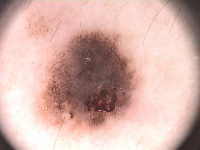</td><td>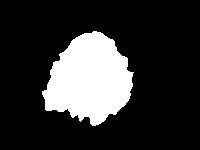</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем сегментировать их.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

Для загрузки датасета я предлагаю использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = '/content/drive/My Drive/Обучение машин/Дз 16/PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize) можно использовать для изменения размера изображений. 
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

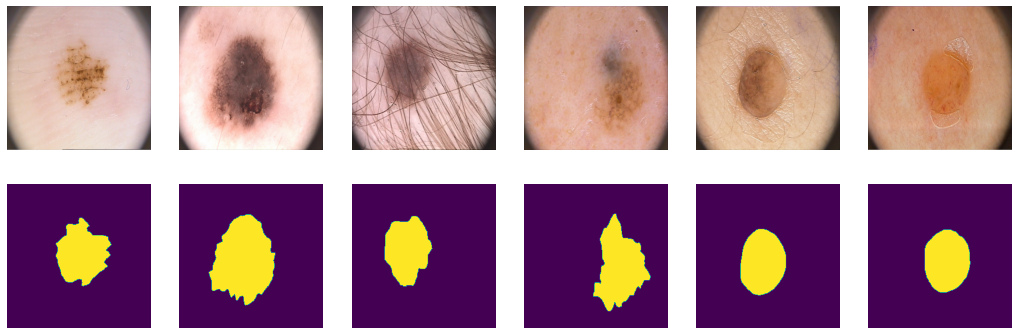

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для валидации и теста

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

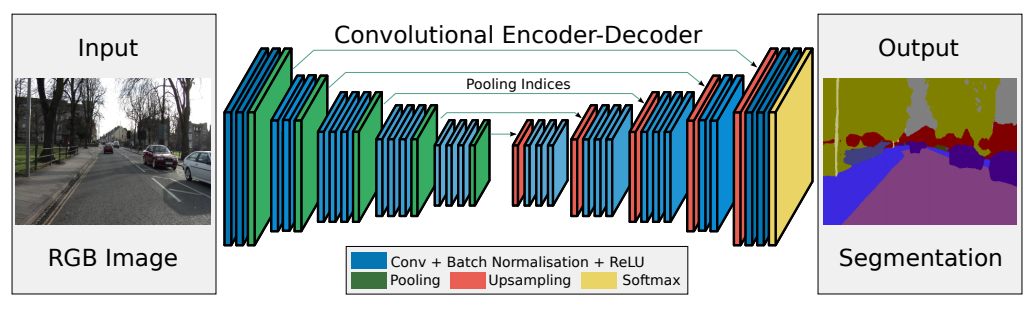

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.pool0 =  nn.MaxPool2d(2,  padding=0) # 256 -> 128
        print(self.pool0)
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            )
        self.pool1 = nn.MaxPool2d(2, padding=0) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            )
        self.pool2 = nn.MaxPool2d(2, padding=0) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            )
        self.pool3 = nn.MaxPool2d(2, padding=0) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU() 
        )

        
        # decoder (upsampling)
        self.upsample0 = nn.UpsamplingBilinear2d(32) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            )
        self.upsample1 =  nn.UpsamplingBilinear2d(64)# 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            )
        self.upsample2 =  nn.UpsamplingBilinear2d(128) # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            )
        self.upsample3 =  nn.UpsamplingBilinear2d(256) # 128 -> 256
        self.dec_conv3 =nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1),
            # nn.ReLU(),
            )

    def forward(self, x):
        # encoder
        e0 = self.pool0(self.enc_conv0(x))
        e1 = self.pool1(self.enc_conv1(e0))
        e2 = self.pool2(self.enc_conv2(e1))
        e3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.upsample0(self.dec_conv0(b))
        d1 = self.upsample1(self.dec_conv1(d0))
        d2 = self.upsample2(self.dec_conv2(d1))
        d3 = self.upsample3(self.dec_conv3(d2))  # no activation
        return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


To clarify this we can see on the segmentation:
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


And the intersection will be the following:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

## функция лосса [1 балл]

Теперь не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) в Тарая функция эквивалентна и не так подвержена численной неустойчивости.

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
def bce_loss(y_pred, y_real ):
    # TODO 
    # please don't use nn.BCELoss. write it from scratch
    
    return torch.mean(torch.max(y_pred, torch.zeros(y_pred.size()).to(device)) - y_pred * y_real + torch.log(1+torch.exp(-torch.abs(y_pred))))

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))
    tr_loss = []
    val_loss = []
    val_score = []
    max_score = -1.0

    for epoch in range(epochs):
        tic = time()
        
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_pred, Y_batch) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)

        tr_loss.append(torch.mean(loss))

        toc = time()
        print('loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        val_pred = model(X_val.to(device)) 
        val_loss.append(loss_fn(val_pred, Y_val.to(device)).detach().to('cpu'))
        val_score.append(score_model(model, iou_pytorch, data_val))
        if val_score[-1] > max_score:
          torch.save(model.state_dict(), 'best_val.pth')
          max_score = val_score[-1]

        X_batch_hat = X_batch.detach().to('cpu')
        Y_train_hat = Y_batch.detach().to('cpu')
        Y_hat = Y_pred.detach().to('cpu') # detach and put into cpu

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(3, 6, k+1)
            plt.imshow(np.rollaxis(X_batch_hat[k].numpy(), 0, 3), cmap='gray') #bug!!!
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 6, k+7)
            plt.imshow(Y_train_hat[k, 0], cmap='gray')
            plt.title('Expected mask')
            plt.axis('off')

            plt.subplot(3, 6, k+13)
            plt.imshow(Y_hat[k, 0], cmap='gray')            
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

    return (tr_loss, val_loss, val_score)

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [model(X_batch.to(device))  for X_batch, _ in data]
    return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = model(X_batch.to(device))
        scores += metric(Y_pred > 0.5, Y_label.to(device)).mean().item()

    return scores/len(data)

-----------------------------------------------------------------------------------------

## Дополнительные функции лосса [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

//  Не забудьте подумать о численной нестабильности.


In [ ]:
def dice_loss(target, input ):
    input = torch.sigmoid(input)
    smooth = 1.0

    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return 1 - ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    BCE_loss = bce_loss(y_pred, y_real)
    pt = torch.sigmoid(-BCE_loss)
    F_loss = (1-pt)**gamma * BCE_loss
    return torch.mean(F_loss)

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаю написать вам 1 функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Tversky loss
5) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

<div style="border-left: solid 6px #d6d6d6; padding: 10px; background-color: #eaeaea">
<b><i>Exercise:</i></b> Add the total variation term to the loss.</div>

In [ ]:
def tversky_loss(inputs, targets, smooth=1, alpha=0.9, beta=0.1):
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()    
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
       
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        
        return 1 - Tversky

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Учитывая медицинское изображение, он выводит изображение в оттенках серого, представляющее вероятность того, что каждый пиксель является интересующей областью.

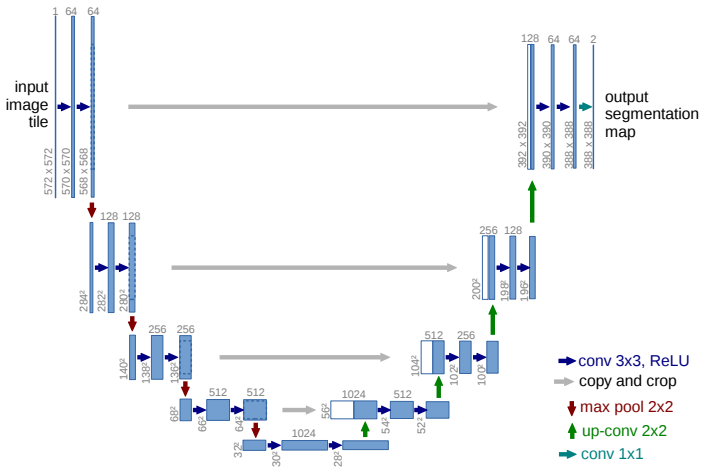

У нас в архитектуре все так же существует енкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются skip-conenctions. Элементы соединяющие части декодера и енкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.pool0 =  nn.MaxPool2d(2,  padding=0) # 256 -> 128
        print(self.pool0)
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            )
        self.pool1 = nn.MaxPool2d(2, padding=0) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            )
        self.pool2 = nn.MaxPool2d(2, padding=0) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            )
        self.pool3 = nn.MaxPool2d(2, padding=0) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        
        # decoder (upsampling)
        self.upsample0 = nn.UpsamplingBilinear2d(32) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            )
        self.upsample1 =  nn.UpsamplingBilinear2d(64)# 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            )
        self.upsample2 =  nn.UpsamplingBilinear2d(128) # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            )
        self.upsample3 =  nn.UpsamplingBilinear2d(256) # 128 -> 256
        self.dec_conv3 =nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1),
            # nn.ReLU(),
            )

    def forward(self, x):
        # encoder
        e0 = self.pool0(self.enc_conv0(x))
        e1 = self.pool1(self.enc_conv1(e0))
        e2 = self.pool2(self.enc_conv2(e1))
        e3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = torch.cat((b, e3), dim=1)
        d0 = self.upsample0(self.dec_conv0(d0))
        d1 = torch.cat((d0, e2), dim=1)
        d1 = self.upsample1(self.dec_conv1(d1))
        d2 = torch.cat((d1, e1), dim=1)
        d2 = self.upsample2(self.dec_conv2(d2))
        d3 = torch.cat((d2, e0), dim=1)
        d3 = self.upsample3(self.dec_conv3(d3))  # no activation
        return d3

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [ ]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.pool0 =  nn.Conv2d(32, 32, kernel_size=3, stride=2) # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            )
        self.pool1 = nn.Conv2d(64, 64,kernel_size=3,  stride=2) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            )
        self.pool2 = nn.Conv2d(128, 128, kernel_size=3, stride=2) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            )
        self.pool3 = nn.Conv2d(256, 256, kernel_size=3, stride=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        
        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, stride=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            )
        self.upsample1 = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            )
        self.upsample2 =  nn.ConvTranspose2d(32, 32,kernel_size=3, stride=2) # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            )
        self.upsample3 =  nn.ConvTranspose2d(16, 16 ,kernel_size=3, stride=2) # 128 -> 256
        self.dec_conv3 =nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            )
        self.final = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=1, kernel_size=2, padding=1),
            nn.BatchNorm2d(1),
        )

    def forward(self, x):
        # encoder
        e0 = self.pool0(self.enc_conv0(x))
        e1 = self.pool1(self.enc_conv1(e0))
        e2 = self.pool2(self.enc_conv2(e1))
        e3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = torch.cat((b, e3), dim=1)
        d0 = self.upsample0(self.dec_conv0(d0))
        d1 = torch.cat((d0, e2), dim=1)
        d1 = self.upsample1(self.dec_conv1(d1))
        d2 = torch.cat((d1, e1), dim=1)
        d2 = self.upsample2(self.dec_conv2(d2))
        d3 = torch.cat((d2, e0), dim=1)
        d3 = self.upsample3(self.dec_conv3(d3))  # no activation
        return self.final(d3)


Сделайте вывод какая из моделей лучше

# Dilated convolutions [1 балл]



Еще один из вариантов делать upsampling и downsampling - использовать для этого *dilated convolutions*:


* Yu, Fisher, and Vladlen Koltun. "[Multi-scale context aggregation by dilated convolutions.](https://arxiv.org/pdf/1511.07122.pdf)" arXiv preprint arXiv:1511.07122 (2015).

попробуйте написать сеть DilatedUNet, которая использует в одной из предыдущих моделей dilated свертки.

In [ ]:
class DilatedSegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1, dilation=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1, dilation=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.pool0 =  nn.MaxPool2d(2,  padding=0) # 256 -> 128
        print(self.pool0)
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, dilation=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, dilation=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            )
        self.pool1 = nn.MaxPool2d(2, padding=0) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, dilation=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, dilation=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            )
        self.pool2 = nn.MaxPool2d(2, padding=0) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, dilation=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, dilation=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            )
        self.pool3 = nn.MaxPool2d(2, padding=0) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, dilation=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, dilation=2),
            nn.ReLU() 
        )

        
        # decoder (upsampling)
        self.upsample0 = nn.UpsamplingBilinear2d(32) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1, dilation=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, dilation=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            )
        self.upsample1 =  nn.UpsamplingBilinear2d(64)# 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1, dilation=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, dilation=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            )
        self.upsample2 =  nn.UpsamplingBilinear2d(128) # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1, dilation=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1, dilation=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            )
        self.upsample3 =  nn.UpsamplingBilinear2d(256) # 128 -> 256
        self.dec_conv3 =nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1, dilation=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding=1, dilation=2),
            nn.BatchNorm2d(1),
            # nn.ReLU(),
            )

    def forward(self, x):
        # encoder
        e0 = self.pool0(self.enc_conv0(x))
        e1 = self.pool1(self.enc_conv1(e0))
        e2 = self.pool2(self.enc_conv2(e1))
        e3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.upsample0(self.dec_conv0(b))
        d1 = self.upsample1(self.dec_conv1(d0))
        d2 = self.upsample2(self.dec_conv2(d1))
        d3 = self.upsample3(self.dec_conv3(d2))  # no activation
        return d3

# Отчет (5 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 

Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверябщий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.



## Эффективный лосс 
Обучим каждую модель с разными лоссами 50 эпох и сравним показатели метрик.

In [ ]:
def compare_losses(arch, max_epochs=100):

    model_1 = arch.to(device)
    optimaizer_1 = torch.optim.AdamW(model_1.parameters())
    bce = train(model_1, optimaizer_1, bce_loss, max_epochs, data_tr, data_val)

    model_2 = arch.to(device)
    optimaizer_2 = torch.optim.AdamW(model_2.parameters())
    dice = train(model_2, optimaizer_2, dice_loss, max_epochs, data_tr, data_val)

    model_3 = arch.to(device)
    optimaizer_3 = torch.optim.AdamW(model_3.parameters())
    focal = train(model_3, optimaizer_3, focal_loss, max_epochs, data_tr, data_val)
    
    model_4 = arch.to(device)
    optimaizer_4 = torch.optim.AdamW(model_4.parameters())
    tversky = train(model_4, optimaizer_4, tversky_loss, max_epochs, data_tr, data_val)

    

    plt.figure(figsize=(10, 5))

    plt.plot(bce[2], label='BCE')
    plt.plot(dice[2], label='DICE')
    plt.plot(focal[2], label='FOCAL')
    plt.plot(tversky[2], label='TVERSKY')

    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()
    plt.show()

    print("Max score BCE = %.2f" % max(bce[2]))
    print("Max score DICE = %.2f" % max(dice[2]))
    print("Max score FOCAL = %.2f" % max(focal[2]))
    print("Max score TVERSKY = %.2f" % max(tversky[2]))

#### Segnet

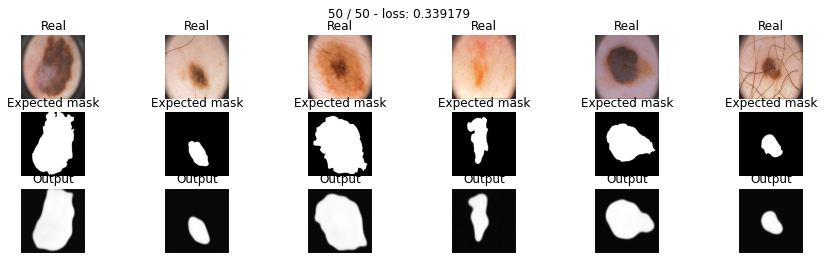

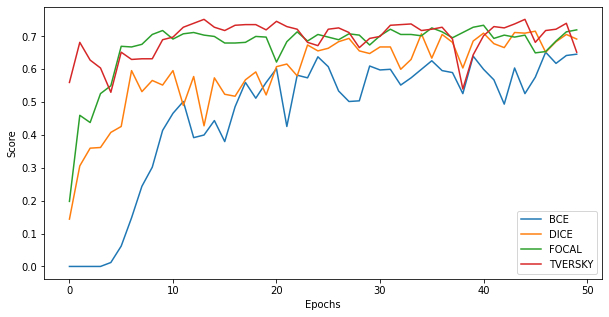

Max score BCE = 0.65
Max score DICE = 0.72
Max score FOCAL = 0.73
Max score TVERSKY = 0.75


In [ ]:
compare_losses(SegNet(), 50)

#### Unet

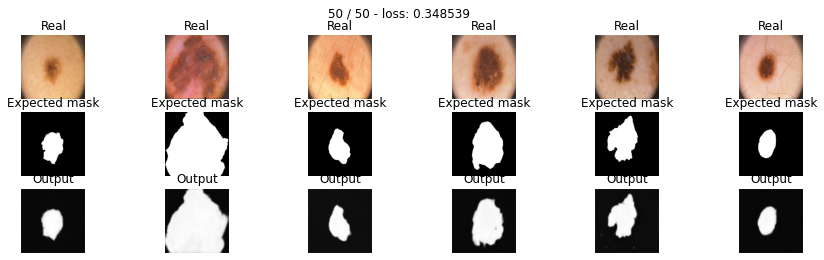

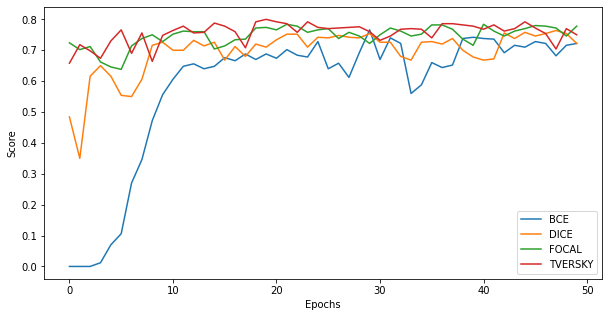

Max score BCE = 0.77
Max score DICE = 0.76
Max score FOCAL = 0.78
Max score TVERSKY = 0.80


In [ ]:
compare_losses(UNet(), 50)

#### Dialted SegNet

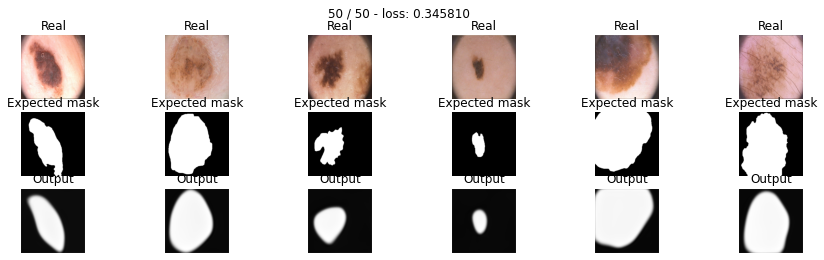

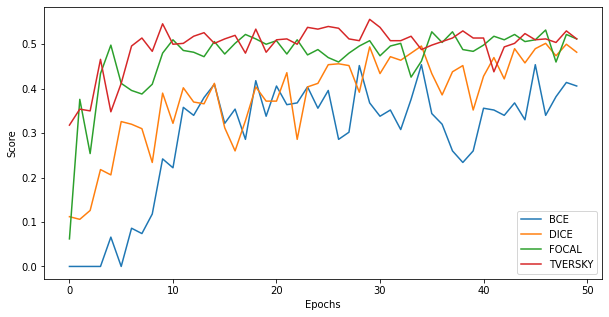

Max score BCE = 0.45
Max score DICE = 0.50
Max score FOCAL = 0.53
Max score TVERSKY = 0.56


In [ ]:
compare_losses(DilatedSegNet(), 50)

#### Unet2

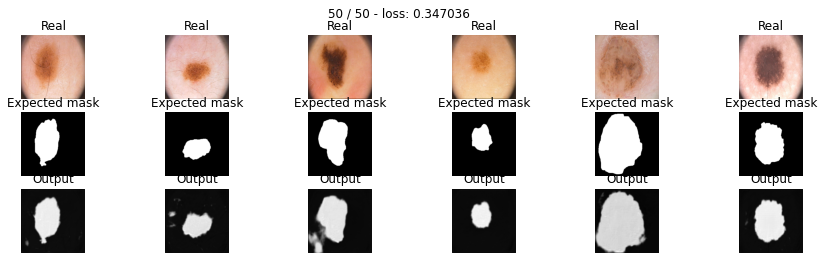

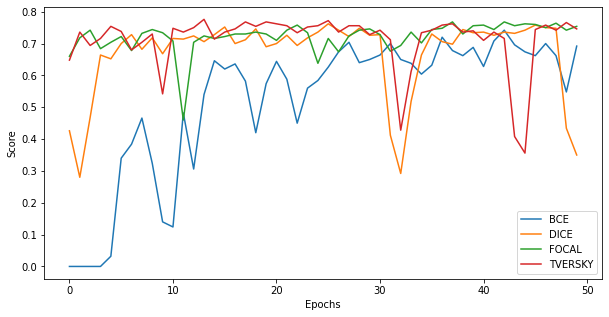

Max score BCE = 0.74
Max score DICE = 0.76
Max score FOCAL = 0.77
Max score TVERSKY = 0.78


In [ ]:
compare_losses(UNet2(), 50)

Как видно из графиков, самый эффективный лосс - Тверски. 

## Наиболее эффективная модель

Сравним модели + Тверски лосс на тестовом датасете

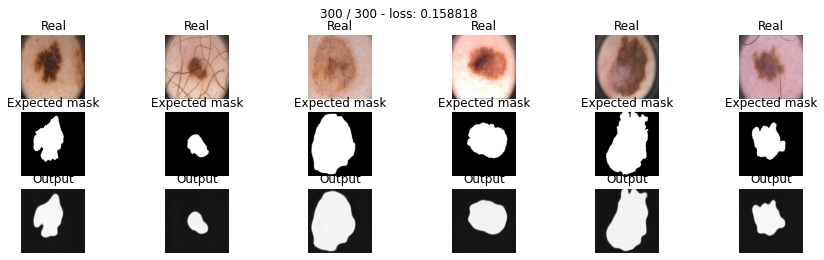

<All keys matched successfully>

In [ ]:
seg = SegNet().to(device)
optimaizer = torch.optim.AdamW(seg.parameters(), amsgrad=True)
seg_loss = train(seg, optimaizer, tversky_loss, 300, data_tr, data_val)
seg.load_state_dict(torch.load('best_val.pth'))

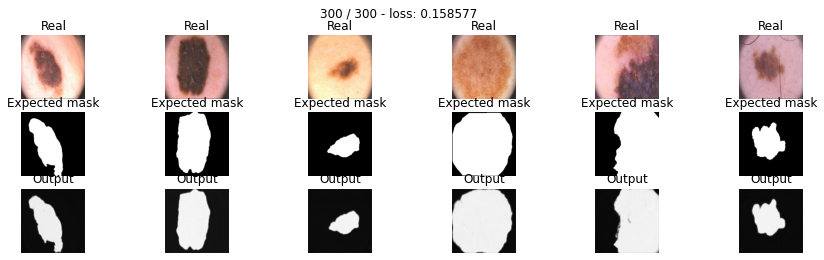

<All keys matched successfully>

In [ ]:
u = UNet().to(device)
optimaizer = torch.optim.AdamW(u.parameters(), amsgrad=True)
u_loss = train(u, optimaizer, tversky_loss, 300, data_tr, data_val)
u.load_state_dict(torch.load('best_val.pth'))

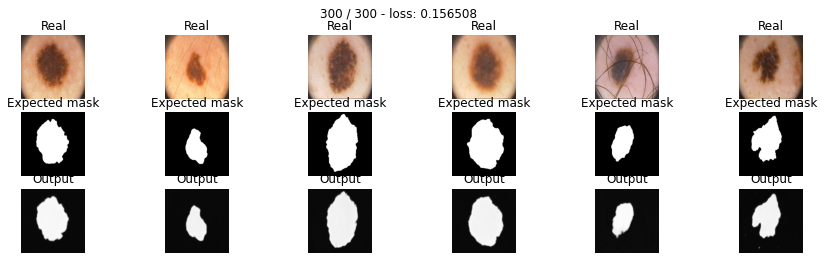

<All keys matched successfully>

In [ ]:
u2 = UNet2().to(device)
optimaizer = torch.optim.AdamW(u2.parameters(), amsgrad=True)
u2_loss = train(u2, optimaizer, tversky_loss, 300, data_tr, data_val)
u2.load_state_dict(torch.load('best_val.pth'))

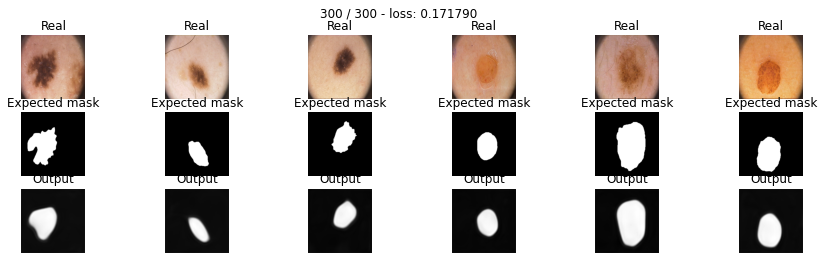

<All keys matched successfully>

In [ ]:
dilated_seg = DilatedSegNet().to(device)
optimaizer = torch.optim.AdamW(dilated_seg.parameters(), amsgrad=True)
dilated_seg_loss = train(dilated_seg, optimaizer, tversky_loss, 300, data_tr, data_val)
dilated_seg.load_state_dict(torch.load('best_val.pth'))

In [ ]:
score_model(seg, iou_pytorch, data_ts)

0.8019999563694

In [ ]:
score_model(u, iou_pytorch, data_ts)

0.7940000593662262

In [ ]:
score_model(u2, iou_pytorch, data_ts)

0.742000013589859

In [ ]:
score_model(dilated_seg, iou_pytorch, data_ts)

0.578000009059906

Как видно из показателя IoU, наибольший результат на данной задаче показала обычная SegNet. Однако, по графикам выше, UNet обучился быстрее, поэтому при больших данных выгоднее использовать его.